# Impact of 3.2 Beer in Minnesota

In [3]:
# packages used
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, Birch, DBSCAN, FeatureAgglomeration, KMeans, MiniBatchKMeans, MeanShift, SpectralClustering
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab as pl
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [4]:
%run ../cluster_GridSearch3.py

### Load Data

In [5]:
#Stores Data
Stores = pd.read_csv('MinnesotaStoreDataV1.csv')
#Stores Classification data
StoresClass = pd.read_csv('NonLowPointStoresMinnesotaV1.csv', dtype = str)

In [6]:
Stores.head()

,STORE_CD,L12M_TY_QTY,PREMISE_TYPE_DSC,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,BEER_FLG,...,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT
0,202196323,17.0000,ON PREMISE,RECREATION,THEATER,AMERICAN,LOWEST 20% ON/ LOWEST 20% OFF,Y,N,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,103793493,397.8332,ON PREMISE,DINING,CASUAL DINING,MEXICAN,MID 30% ON/ MID 60% OFF,N,N,Y,...,0.0581,0.0354,0.0216,0.0201,0.1052,0.0728,0.0595,0.0599,0.0413,0.0334
2,105645970,NaN,ON PREMISE,DINING,FINE DINING,ITALIAN,LOWEST 20% ON/ LOWEST 20% OFF,N,N,Y,...,0.0584,0.0364,0.0228,0.0192,0.0942,0.0728,0.0617,0.0621,0.0436,0.0365
3,103779046,0.0000,OFF PREMISE,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,OTHER,LOWEST 20% ON/ LOWEST 20% OFF,N,N,Y,...,0.0483,0.0305,0.0135,0.0589,0.1088,0.0667,0.0420,0.0450,0.0310,0.0185
4,105646503,13.0000,ON PREMISE,BAR/NIGHTCLUB,CASUAL NIGHTCLUB,OTHER,TOP 50% ON/ TOP 20% OFF,N,N,Y,...,0.0658,0.0376,0.0240,0.0230,0.0546,0.0669,0.0703,0.0619,0.0402,0.0338


#### Clean Data

In [7]:

#Remove Stores without Depletion data for the last year (NAs)
Stores = Stores.loc[Stores['L12M_TY_QTY'].notnull(),:]
print('Stores after removing stores with no depletion data ',len(Stores))

#Remove Stores with Negative Depletion data for the last year
Stores = Stores.loc[Stores['L12M_TY_QTY'] > 0,:] 
print('Stores after removing stores with negative ',len(Stores))

#Remove Stores without Demographic data (NAs)
Stores = Stores.loc[Stores['MALE_POP_5564_PCT'].notnull(),:]
print('Stores after removing stores with no demographic data ',len(Stores))

Stores = Stores.reset_index(drop=True)

#Change Y and N to 1 and 0
Stores['CHAIN_IND_FLG'] = Stores['CHAIN_IND_FLG']=='Y'
Stores['FRANCHISE_FLG'] = Stores['FRANCHISE_FLG']=='Y'
Stores['BEER_FLG'] = Stores['BEER_FLG']=='Y'
Stores['WINE_FLG'] = Stores['WINE_FLG']=='Y'
Stores['LIQUOR_FLG'] = Stores['LIQUOR_FLG']=='Y'
Stores['FINE_WINE_FLG'] = Stores['FINE_WINE_FLG']=='Y'

Stores['STORE_CD'] = Stores['STORE_CD'].astype(str)

Stores after removing stores with no depletion data  6931
Stores after removing stores with negative  6303
Stores after removing stores with no demographic data  5400


In [8]:
#Divide stores data into ON PREMISE and OFF PREMISE

StoresON = Stores[Stores.PREMISE_TYPE_DSC == 'ON PREMISE'].reset_index(drop=True)
StoresOFF = Stores[Stores.PREMISE_TYPE_DSC == 'OFF PREMISE'].reset_index(drop=True)


## ON PREMISE ANALYSIS

### Data Preprocessing

##### Exploratory Analysis of the columns

In [9]:
StoresON.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'PREMISE_TYPE_DSC', 'CHANNEL_DSC',
       'SUBCHANNEL_DSC', 'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC',
       'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'BEER_FLG', 'WINE_FLG', 'LIQUOR_FLG',
       'FINE_WINE_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [10]:
len(StoresON.columns)

43

In [11]:
for col in StoresON.columns:
    print(StoresON[col].describe())

count          3465
unique         3465
top       105646936
freq              1
Name: STORE_CD, dtype: object
count    3465.000000
mean       74.289954
std       220.638652
min         0.583300
25%         9.000000
50%        22.000000
75%        53.888900
max      5758.111900
Name: L12M_TY_QTY, dtype: float64
count           3465
unique             1
top       ON PREMISE
freq            3465
Name: PREMISE_TYPE_DSC, dtype: object
count       3465
unique         5
top       DINING
freq        1707
Name: CHANNEL_DSC, dtype: object
count              3465
unique               20
top       CASUAL DINING
freq               1455
Name: SUBCHANNEL_DSC, dtype: object
count      3465
unique       11
top       OTHER
freq       1398
Name: FOOD_TYPE_GROUP_DSC, dtype: object
count                              3465
unique                                3
top       LOWEST 20% ON/ LOWEST 20% OFF
freq                               1980
Name: INDUSTRY_VOL_DSC, dtype: object
count      3465
unique        

In [12]:
#Remove Not Necessary Columns
del StoresON['PREMISE_TYPE_DSC'] #Unique
del StoresON['BEER_FLG'] # No Variance
del StoresON['FINE_WINE_FLG'] # No Variance
del StoresON['CHAIN_IND_FLG']
del StoresON['FRANCHISE_FLG']
del StoresON['INDUSTRY_VOL_DSC']

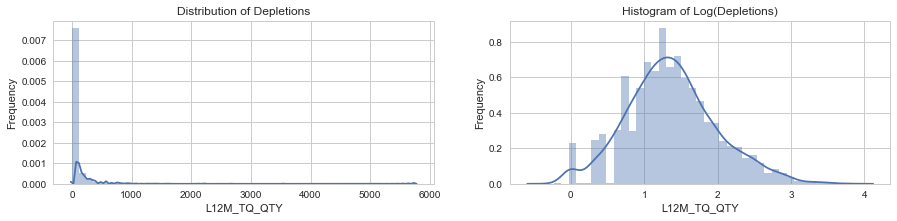

In [13]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,2)
plt.title('Histogram of Log(Depletions)')
sns.distplot(np.log10(StoresON['L12M_TY_QTY'].values))
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

plt.subplot(1,2,1)
plt.title('Distribution of Depletions')
sns.distplot(StoresON['L12M_TY_QTY'])
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

In [14]:
#Binarize function
def binarize(dataframe , column):
    dataframe = pd.concat([dataframe ,pd.get_dummies(dataframe[column] , prefix = ['B_'+c for c in column])] , axis = 1)
    return(dataframe)

In [15]:
StoresON.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'CHANNEL_DSC', 'SUBCHANNEL_DSC',
       'FOOD_TYPE_GROUP_DSC', 'WINE_FLG', 'LIQUOR_FLG', 'WHITE_POP_PCT',
       'BLACK_POP_PCT', 'ASIAN_POP_PCT', 'HISP_POP_PCT',
       'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [16]:
#Get Dummies
#DummiesColumnsON = ['CHANNEL_DSC','INDUSTRY_VOL_DSC']
#StoresC_ON = binarize(StoresON, DummiesColumnsON)

#Normalize Depletions using Min-Max method
StoresC_ON = StoresON #Change if we add dummies again
scaler = MinMaxScaler() 
StoresC_ON['NORM_L12M_TY_QTY'] = scaler.fit_transform(StoresON['L12M_TY_QTY'].values.reshape(-1,1)) 


In [17]:
# prepare data to fit model
X_labels_ON = [c for c in StoresC_ON.columns if c not in ['CHANNEL_DSC','SUBCHANNEL_DSC','FOOD_TYPE_GROUP_DSC','INDUSTRY_VOL_DSC',
                                                     'STORE_CD','L12M_TY_QTY']]
X_ON = StoresC_ON.loc[:,X_labels_ON]

In [18]:
X_ON.head()

,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,OTHER_POP_PCT,...,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY
0,True,True,0.7596,0.1108,0.0554,0.0474,0.0118,0.0172,0.0185,0.0204,...,0.0354,0.0216,0.0201,0.1052,0.0728,0.0595,0.0599,0.0413,0.0334,0.068997
1,True,True,0.9312,0.0072,0.0114,0.0421,0.0087,0.0138,0.0195,0.0061,...,0.0376,0.0240,0.0230,0.0546,0.0669,0.0703,0.0619,0.0402,0.0338,0.002157
2,True,True,0.7775,0.0035,0.0019,0.0119,0.0026,0.0038,0.0055,0.0166,...,0.1062,0.0501,0.0184,0.0411,0.0345,0.0530,0.0845,0.1039,0.0463,0.000941
3,True,True,0.9530,0.0062,0.0091,0.0240,0.0057,0.0077,0.0105,0.0050,...,0.0455,0.0313,0.0239,0.0597,0.0594,0.0636,0.0676,0.0530,0.0532,0.057355
4,True,True,0.9072,0.0204,0.0270,0.0363,0.0076,0.0120,0.0167,0.0073,...,0.0456,0.0330,0.0229,0.0584,0.0588,0.0626,0.0695,0.0491,0.0463,0.004762


In [19]:
X_ON.columns

Index(['WINE_FLG', 'LIQUOR_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT',
       'ASIAN_POP_PCT', 'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT',
       'BI_CULTURAL_HISP_POP_PCT', 'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT',
       'INCOME_POP_L10_PCT', 'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT',
       'INCOME_POP_3040_PCT', 'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT',
       'INCOME_POP_75100_PCT', 'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT',
       'MALE_POP_2534_PCT', 'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT',
       'MALE_POP_5564_PCT', 'MALE_POP_6574_PCT', 'MALE_POP_75_PCT',
       'FEMALE_POP_2124_PCT', 'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT',
       'FEMALE_POP_4554_PCT', 'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT',
       'FEMALE_POP_75_PCT', 'NORM_L12M_TY_QTY'],
      dtype='object')

### Clustering

#### Choose number of Clusters and algorithm using Grid Search

In [20]:
model_param = {'KMeans':{'model':KMeans(),
                         'n_clusters':range(2,15,1),
                         'n_jobs':[-2]},
               'AffinityProp':{'model':AffinityPropagation(),
                              'damping':np.arange(0.5,0.9,0.1)},
               'MeanShift':{'model':MeanShift(),
                              'n_jobs':[-2]},
               'DBSCAN':{'model':DBSCAN(),
                         'eps':np.arange(0.2,0.9,0.1), 
                         'min_samples':range(5,200,20),
                         'n_jobs':[-2]}
              }

In [21]:
perf_metric = {'Silhouette':{'metric':'euclidean',
                             'random_state':1}}

In [22]:
#Cluster Grid Search
cluster_GridSearch(X_ON, model_param, perf_metric)

OPTIMAL MODEL
Model: DBSCAN
Parameters: {'eps': 0.50000000000000011, 'min_samples': 5, 'n_jobs': -2}
Clusters: 4
Silhouette: 0.7648676845966041


{'Model': 'DBSCAN',
 'Parameters': {'eps': 0.50000000000000011, 'min_samples': 5, 'n_jobs': -2},
 'Silhouette': 0.76486768459660415,
 'Trained_Model': DBSCAN(algorithm='auto', eps=0.50000000000000011, leaf_size=30,
     metric='euclidean', min_samples=5, n_jobs=-2, p=None)}

In [23]:
#Cluster the Data ON
cluster_model = cluster.DBSCAN(eps= 0.5, min_samples=5, n_jobs=-2).fit(X_ON)
labels = cluster_model.labels_

In [24]:
#Assign Cluster to Data
StoresON['CLUSTER'] = labels

In [25]:
StoresON.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,...,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY,CLUSTER
0,103793493,397.8332,DINING,CASUAL DINING,MEXICAN,True,True,0.7596,0.1108,0.0554,...,0.0216,0.0201,0.1052,0.0728,0.0595,0.0599,0.0413,0.0334,0.068997,0
1,105646503,13.0000,BAR/NIGHTCLUB,CASUAL NIGHTCLUB,OTHER,True,True,0.9312,0.0072,0.0114,...,0.0240,0.0230,0.0546,0.0669,0.0703,0.0619,0.0402,0.0338,0.002157,0
2,105645328,6.0000,DINING,CASUAL DINING,VARIED MENU,True,True,0.7775,0.0035,0.0019,...,0.0501,0.0184,0.0411,0.0345,0.0530,0.0845,0.1039,0.0463,0.000941,0
3,202252793,330.8054,DINING,CASUAL DINING,MEXICAN,True,True,0.9530,0.0062,0.0091,...,0.0313,0.0239,0.0597,0.0594,0.0636,0.0676,0.0530,0.0532,0.057355,0
4,105649082,28.0000,LODGING,FULL SERVICE LODGING,OTHER,True,True,0.9072,0.0204,0.0270,...,0.0330,0.0229,0.0584,0.0588,0.0626,0.0695,0.0491,0.0463,0.004762,0


### Regression Analysis

In [26]:
#Merge Class with StoreON Data for regression
RegressionDataON = pd.merge(StoresON, StoresClass, left_on='STORE_CD', right_on="RTL_STORE_CD", how="left")
RegressionDataON.loc[RegressionDataON['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [27]:
RegressionDataON.tail()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,...,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY,CLUSTER,RTL_STORE_CD,BEERTYPE
3460,105645016,28.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,AMERICAN,True,True,0.9022,0.0233,0.0326,...,0.0533,0.0692,0.0792,0.0621,0.0352,0.0193,0.004762,0,105645016,NonLowPoint
3461,105646544,32.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,True,True,0.9169,0.0187,0.0286,...,0.0561,0.0761,0.0764,0.0551,0.0313,0.0175,0.005457,0,105646544,NonLowPoint
3462,105646682,8.0,BAR/NIGHTCLUB,COUNTRY WESTERN,OTHER,True,True,0.7824,0.0902,0.0679,...,0.0718,0.0686,0.0699,0.0671,0.0418,0.0278,0.001288,0,105646682,NonLowPoint
3463,105646574,9.0,BAR/NIGHTCLUB,COUNTRY WESTERN,OTHER,True,True,0.8455,0.0381,0.0579,...,0.0596,0.0693,0.0757,0.0665,0.0395,0.0255,0.001462,0,105646574,NonLowPoint
3464,105646371,514.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,True,True,0.7368,0.0466,0.1295,...,0.0665,0.0865,0.0724,0.0490,0.0267,0.0162,0.089173,0,105646371,NonLowPoint


In [28]:
len(RegressionDataON)

3465

### Analysis of the Clusters

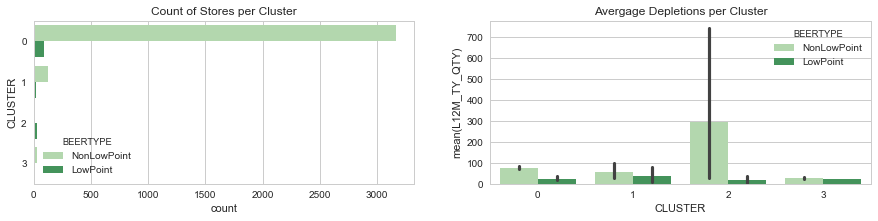

In [32]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "BEERTYPE", data=RegressionDataON, palette="Greens");

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="L12M_TY_QTY", hue="BEERTYPE", data=RegressionDataON, palette="Greens");

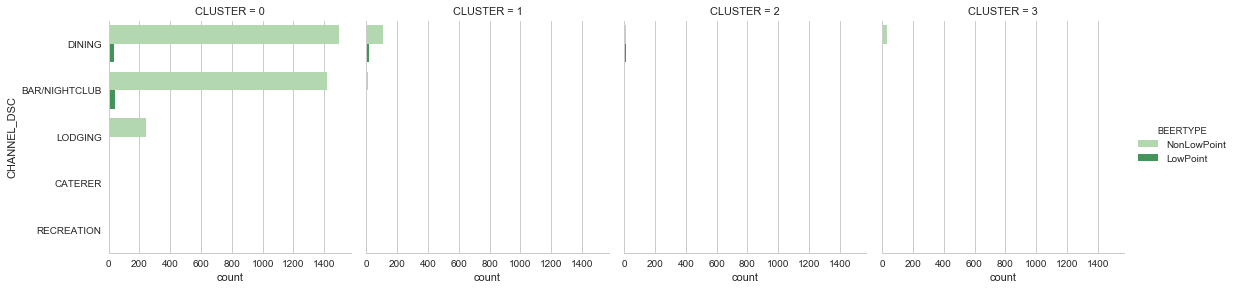

In [33]:
sns.factorplot(y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataON, kind="count", palette="Greens");

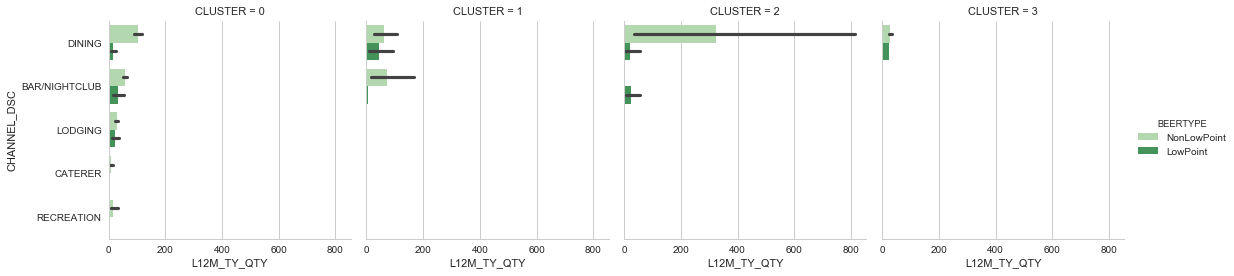

In [34]:
sns.factorplot(x='L12M_TY_QTY' ,y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataON, kind="bar", palette="Greens");

### Regression controlling for Cluster

In [35]:
#Regression ON Premise
modON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)*C(CLUSTER)', data=RegressionDataON)
print(modON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.029
Model:                             OLS   Adj. R-squared:                  0.027
Method:                  Least Squares   F-statistic:                     14.58
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):           7.81e-19
Time:                         13:50:25   Log-Likelihood:                -6070.6
No. Observations:                 3465   AIC:                         1.216e+04
Df Residuals:                     3457   BIC:                         1.221e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [36]:
#Regression ON Premise
modON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE) + C(CLUSTER)', data=RegressionDataON)
print(modON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.027
Model:                             OLS   Adj. R-squared:                  0.026
Method:                  Least Squares   F-statistic:                     23.73
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):           2.20e-19
Time:                         13:50:30   Log-Likelihood:                -6074.2
No. Observations:                 3465   AIC:                         1.216e+04
Df Residuals:                     3460   BIC:                         1.219e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

### Regression Based on Selected Cluster

#### Cluster 2

In [43]:
mod2ON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataON.loc[RegressionDataON["CLUSTER"]==2,:])
print(mod2ON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.171
Model:                             OLS   Adj. R-squared:                  0.149
Method:                  Least Squares   F-statistic:                     7.655
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):            0.00879
Time:                         13:51:35   Log-Likelihood:                -75.894
No. Observations:                   39   AIC:                             155.8
Df Residuals:                       37   BIC:                             159.1
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

## OFF PREMISE ANALYSIS

### Data Preprocessing

##### Exploratory Analysis of the columns

In [44]:
StoresOFF.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'PREMISE_TYPE_DSC', 'CHANNEL_DSC',
       'SUBCHANNEL_DSC', 'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC',
       'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'BEER_FLG', 'WINE_FLG', 'LIQUOR_FLG',
       'FINE_WINE_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [45]:
len(StoresOFF.columns)

43

In [46]:
for col in StoresOFF.columns:
    print(StoresOFF[col].describe())

count          1935
unique         1935
top       100998603
freq              1
Name: STORE_CD, dtype: object
count     1935.000000
mean       655.879266
std       1872.685344
min          1.000000
25%         34.000000
50%        146.000000
75%        626.958200
max      42742.964700
Name: L12M_TY_QTY, dtype: float64
count            1935
unique              1
top       OFF PREMISE
freq             1935
Name: PREMISE_TYPE_DSC, dtype: object
count       1935
unique         8
top       LIQUOR
freq        1076
Name: CHANNEL_DSC, dtype: object
count                    1935
unique                     14
top       CONVENTIONAL LIQUOR
freq                      973
Name: SUBCHANNEL_DSC, dtype: object
count      1935
unique        1
top       OTHER
freq       1935
Name: FOOD_TYPE_GROUP_DSC, dtype: object
count                              1935
unique                                3
top       LOWEST 20% ON/ LOWEST 20% OFF
freq                               1241
Name: INDUSTRY_VOL_DSC, dtype: o

In [47]:
#Remove Not Necessary Columns
del StoresOFF['PREMISE_TYPE_DSC'] #Unique
del StoresOFF['FOOD_TYPE_GROUP_DSC'] #Unique
del StoresOFF['BEER_FLG'] # No Variance
del StoresOFF['FINE_WINE_FLG'] # No Variance
del StoresOFF['CHAIN_IND_FLG']
del StoresOFF['FRANCHISE_FLG']
del StoresOFF['INDUSTRY_VOL_DSC']

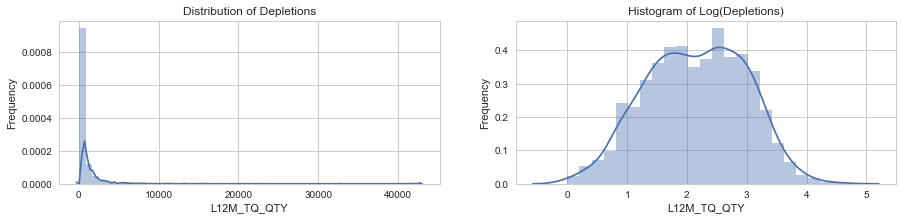

In [48]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,2)
plt.title('Histogram of Log(Depletions)')
sns.distplot(np.log10(StoresOFF['L12M_TY_QTY'].values))
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

plt.subplot(1,2,1)
plt.title('Distribution of Depletions')
sns.distplot(StoresOFF['L12M_TY_QTY'])
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

In [49]:
StoresOFF.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'CHANNEL_DSC', 'SUBCHANNEL_DSC', 'WINE_FLG',
       'LIQUOR_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [50]:
#Get Dummies
#DummiesColumnsOFF = ['CHANNEL_DSC','INDUSTRY_VOL_DSC']
#StoresC_OFF = binarize(StoresOFF, DummiesColumnsOFF)

#Normalize Depletions using Min-Max method
StoresC_OFF = StoresOFF
scaler = MinMaxScaler() 
StoresC_OFF['NORM_L12M_TY_QTY'] = scaler.fit_transform(StoresOFF['L12M_TY_QTY'].values.reshape(-1,1)) 


In [51]:
# prepare data to fit model
X_labels_OFF = [c for c in StoresC_OFF.columns if c not in ['CHANNEL_DSC','SUBCHANNEL_DSC','INDUSTRY_VOL_DSC',
                                                     'STORE_CD','L12M_TY_QTY']]
X_OFF = StoresC_OFF.loc[:,X_labels_OFF]

In [52]:
X_OFF.head()

,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,OTHER_POP_PCT,...,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY
0,True,True,0.9268,0.0038,0.0168,0.0441,0.0098,0.0147,0.0197,0.0057,...,0.0402,0.0258,0.0287,0.0568,0.0611,0.0642,0.0635,0.0399,0.0336,0.019863
1,False,False,0.8122,0.0801,0.0579,0.0300,0.0061,0.0107,0.0132,0.0159,...,0.0423,0.0292,0.0186,0.0831,0.0677,0.0641,0.0732,0.0530,0.0454,0.002082
2,False,False,0.8396,0.0601,0.0472,0.0355,0.0080,0.0130,0.0145,0.0133,...,0.0391,0.0267,0.0157,0.0656,0.0751,0.0709,0.0733,0.0507,0.0475,0.000608
3,True,True,0.9007,0.0271,0.0278,0.0300,0.0059,0.0099,0.0142,0.0112,...,0.0359,0.0240,0.0553,0.0806,0.0568,0.0474,0.0551,0.0388,0.0375,0.005837
4,True,True,0.8278,0.0322,0.0889,0.0371,0.0073,0.0119,0.0179,0.0120,...,0.0403,0.0291,0.0225,0.0758,0.0663,0.0647,0.0698,0.0472,0.0434,0.001199


### Clustering

#### Choose number of Clusters and algorithm using Grid Search

In [53]:
#Cluster Grid Search
cluster_GridSearch(X_OFF, model_param, perf_metric)

OPTIMAL MODEL
Model: KMeans
Parameters: {'n_clusters': 2, 'n_jobs': -2}
Clusters: 14
Silhouette: 0.8116524839534759


{'Model': 'KMeans',
 'Parameters': {'n_clusters': 2, 'n_jobs': -2},
 'Silhouette': 0.81165248395347589,
 'Trained_Model': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=14, n_init=10, n_jobs=-2, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0)}

In [54]:
#Cluster the Data OFF
cluster_model = cluster.KMeans(n_clusters=2, random_state=1, n_jobs = -2).fit(X_OFF)
labels = cluster_model.labels_

In [55]:
#Assign Cluster to Data
StoresOFF['CLUSTER'] = labels

In [56]:
StoresOFF.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,...,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY,CLUSTER
0,101762688,849.9996,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9268,0.0038,0.0168,0.0441,...,0.0258,0.0287,0.0568,0.0611,0.0642,0.0635,0.0399,0.0336,0.019863,0
1,100413001,90.0000,GROCERY,SUPERMARKET-CONVENTIONAL,False,False,0.8122,0.0801,0.0579,0.0300,...,0.0292,0.0186,0.0831,0.0677,0.0641,0.0732,0.0530,0.0454,0.002082,1
2,100570775,27.0000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,False,False,0.8396,0.0601,0.0472,0.0355,...,0.0267,0.0157,0.0656,0.0751,0.0709,0.0733,0.0507,0.0475,0.000608,1
3,100765405,250.5000,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9007,0.0271,0.0278,0.0300,...,0.0240,0.0553,0.0806,0.0568,0.0474,0.0551,0.0388,0.0375,0.005837,0
4,102912880,52.2500,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.8278,0.0322,0.0889,0.0371,...,0.0291,0.0225,0.0758,0.0663,0.0647,0.0698,0.0472,0.0434,0.001199,0


### Regression Analysis

In [57]:
#Merge Class with StoreON Data for regression
RegressionDataOFF = pd.merge(StoresOFF, StoresClass, left_on='STORE_CD', right_on="RTL_STORE_CD", how="left")
RegressionDataOFF.loc[RegressionDataOFF['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [58]:
RegressionDataOFF.tail()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,...,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY,CLUSTER,RTL_STORE_CD,BEERTYPE
1930,100767421,915.4580,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.8298,0.0648,0.0567,0.0314,...,0.0822,0.0624,0.0663,0.0811,0.0570,0.0471,0.021395,0,100767421,NonLowPoint
1931,100078429,820.5000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,False,False,0.6860,0.0818,0.0324,0.1540,...,0.0987,0.0861,0.0653,0.0546,0.0343,0.0160,0.019173,1,NaN,LowPoint
1932,100503120,4207.8744,GROCERY,SUPERCENTER,False,False,0.8729,0.0335,0.0128,0.0683,...,0.0538,0.0578,0.0657,0.0701,0.0483,0.0377,0.098425,1,100503120,NonLowPoint
1933,101406833,164.0000,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9286,0.0029,0.0043,0.0131,...,0.0470,0.0516,0.0630,0.0769,0.0684,0.0479,0.003814,0,101406833,NonLowPoint
1934,101955809,1279.3332,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9700,0.0049,0.0055,0.0130,...,0.0639,0.0560,0.0711,0.0735,0.0482,0.0255,0.029908,0,101955809,NonLowPoint


In [59]:
len(RegressionDataOFF)

1935

### Analysis of the Clusters

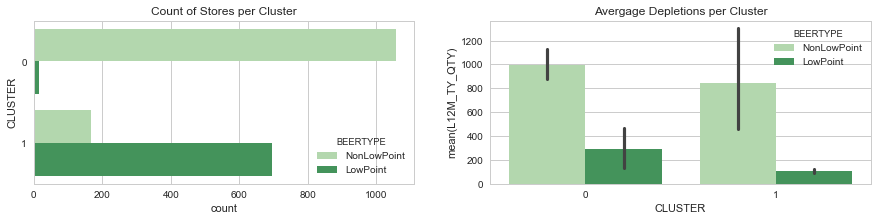

In [63]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "BEERTYPE", data=RegressionDataOFF, palette="Greens");

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="L12M_TY_QTY", hue="BEERTYPE", data=RegressionDataOFF, palette="Greens");

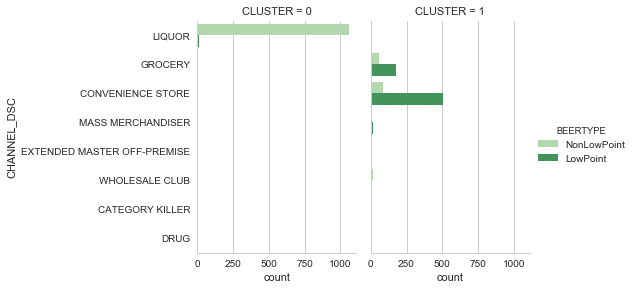

In [64]:
sns.factorplot(y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataOFF, kind="count", palette="Greens");

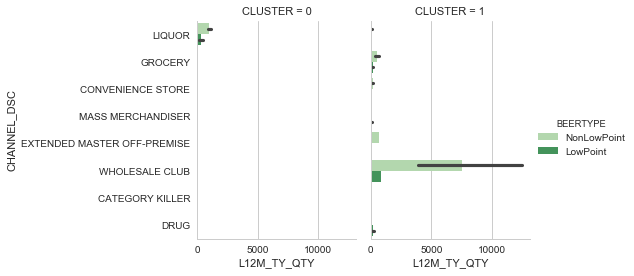

In [65]:
sns.factorplot(x='L12M_TY_QTY' ,y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataOFF, kind="bar", palette="Greens");

### Regression controlling for Cluster

In [60]:
#Regression ON Premise
modOFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE) + C(CLUSTER)', data=RegressionDataOFF)
print(modOFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.275
Model:                             OLS   Adj. R-squared:                  0.274
Method:                  Least Squares   F-statistic:                     366.1
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):          1.52e-135
Time:                         13:58:10   Log-Likelihood:                -3679.2
No. Observations:                 1935   AIC:                             7364.
Df Residuals:                     1932   BIC:                             7381.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

In [61]:
#Regression ON Premise
modOFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)*C(CLUSTER)', data=RegressionDataOFF)
print(modOFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.275
Model:                             OLS   Adj. R-squared:                  0.274
Method:                  Least Squares   F-statistic:                     244.0
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):          3.20e-134
Time:                         13:58:50   Log-Likelihood:                -3679.2
No. Observations:                 1935   AIC:                             7366.
Df Residuals:                     1931   BIC:                             7389.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [62]:
#Regression ON Premise
modOFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataOFF)
print(modOFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.246
Model:                             OLS   Adj. R-squared:                  0.245
Method:                  Least Squares   F-statistic:                     629.7
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):          1.59e-120
Time:                         13:59:15   Log-Likelihood:                -3717.3
No. Observations:                 1935   AIC:                             7439.
Df Residuals:                     1933   BIC:                             7450.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

### Regression Based on Selected Cluster

#### Cluster 1

In [66]:
mod2OFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataOFF.loc[RegressionDataOFF["CLUSTER"]==1,:])
print(mod2OFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.059
Model:                             OLS   Adj. R-squared:                  0.058
Method:                  Least Squares   F-statistic:                     53.67
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):           5.46e-13
Time:                         14:01:30   Log-Likelihood:                -1606.8
No. Observations:                  862   AIC:                             3218.
Df Residuals:                      860   BIC:                             3227.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 